# Topologic Product
#### Jonas Unruh () and Martin Wustinger (12122402)

## Topologic Product Calculator
The TopologicProductCalculator class was designed to efficiently compute the topologic product for a Self-Organizing Map (SOM). It encompasses the logic required to calculate the topological relationships between neurons in the SOM, including k-nearest neighbors and their associated distances. By encapsulating these calculations within a single class, we can effectively manage the necessary arrays, precompute important values, and perform the topologic product computation in an organized and reusable way. This approach ensures the code remains modular, maintainable, and flexible for future updates or enhancements. Additionally, by leveraging numpy for array management instead of relying on Python's standard lists, we achieved a significant performance improvement.

### Method Descriptions

#### `TopologicProductCalculator(som)`
- **Parameters**: `som` (SOM object)
- **Description**: Initializes the `TopologicProductCalculator` with the given SOM. Precomputes weight and Euclidean arrays, as well as k-nearest neighbors and Q values for efficient calculation.

#### `_get_weight_array()`
- **Description**: Internal function that converts the weights from the SOM into a numpy array and swaps axes to access points via '(x, y)'.
- **Output**: Numpy array representing the weight grid of the SOM.

#### `_get_euclidean_array()`
- **Description**: Internal function that converts the Euclidean coordinates of the SOM into a numpy array. Necessary for shapes other than rectangular.
- **Output**: Numpy array of shape (rows, cols, 2) representing the Euclidean coordinates.

#### `_calc_k_nearest_neighbors(weights, xj, yj)`
- **Parameters**: `weights` (numpy array), `xj` (int), `yj` (int)
- **Description**: Internal function that computes the k-nearest neighbors for a given node (xj, yj) using Euclidean distance of the given weights.
- **Output**: Numpy array of coordinates representing the nearest neighbors.

#### `_calc_Q(weights, xj, yj)`
- **Parameters**: `weights` (numpy array), `xj` (int), `yj` (int)
- **Description**: Internal function that calculates the Q value for a given node (xj, yj) by comparing distances to k-nearest neighbors.
- **Output**: Numpy array of Q values.

#### `_calc_P(q, k)`
- **Parameters**: `q` (numpy array), `k` (int)
- **Description**: Internal function that computes the P value as the product of Q values raised to the power of the inverse of `k`.
- **Output**: Float value representing the P value.

#### `k_nearest_neighbor_input(xj, yj, k=None)`
- **Parameters**: `xj` (int), `yj` (int), `k` (optional int)
- **Description**: Returns the k-nearest neighbors for the given SOM position (xj, yj) based on distances in the input space.
- **Output**: Coordinates for the k-nearest input neighbor or numpy array of all input neighbors orderd by distance.

#### `k_nearest_neighbor_output(xj, yj, k=None)`
- **Parameters**: `xj` (int), `yj` (int), `k` (optional int)
- **Description**: Returns the k-nearest neighbors for the given SOM position (xj, yj) based on distances in the output space.
- **Output**: Coordinates for the k-nearest output neighbor or numpy array of all output neighbors orderd by distance.

#### `Q1(xj, yj, k=None)`
- **Parameters**: `xj` (int), `yj` (int), `k` (optional int)
- **Description**: Retrieves the Q1 values for the given SOM position (xj, yj). If `k` is provided, returns the `k`th value.
- **Output**: Q1 value for a given k or numpy array containing all Q1 values ordered by distance.

#### `Q2(xj, yj, k=None)`
- **Parameters**: `xj` (int), `yj` (int), `k` (optional int)
- **Description**: Retrieves the Q2 values for the given SOM position (xj, yj). If `k` is provided, returns the `k`th value.
- **Output**: Q2 value for a given k or numpy array containing all Q2 values ordered by distance.

#### `P1(xj, yj, k)`
- **Parameters**: `xj` (int), `yj` (int), `k` (int)
- **Description**: Calculates the P1 value for the given SOM position (xj, yj) using the Q1 values and the specified `k`.
- **Output**: Float value representing the P1 value.

#### `P2(xj, yj, k)`
- **Parameters**: `xj` (int), `yj` (int), `k` (int)
- **Description**: Calculates the P2 value for the given SOM position (xj, yj) using the Q2 values and the specified `k`.
- **Output**: Float value representing the P2 value.

#### `P3(xj, yj, k)`
- **Parameters**: `xj` (int), `yj` (int), `k` (int)
- **Description**: Calculates the P3 value by combining both Q1 and Q2 values and computing their product raised to the power of the inverse of `2*k`.
- **Output**: Float value representing the P3 value.

#### `P()`
- ***Disclaimer***: This function is computationally very expensive!
- **Description**: Computes the topologic product (P) for the entire SOM, aggregating P3 values across all grid indices and k values.
- **Output**: Float value representing the overall topologic product.

In [ ]:
import numpy as np
from functools import reduce

class TopologicProductCalculator():
    def __init__(self, som):
        self.som = som
        self.w = self._get_weight_array()
        self.e = self._get_euclidean_array()
        
        self.cols = self.w.shape[0] # x-axis
        self.rows = self.w.shape[1] # y-axis
        self.N = self.cols * self.rows

        # Precompute k-nearest neighbors
        self.nIs = np.array([[self._calc_k_nearest_neighbors(self.w, x, y) for y in range(self.rows)] for x in range(self.cols)])
        self.nOs = np.array([[self._calc_k_nearest_neighbors(self.e, x, y) for y in range(self.rows)] for x in range(self.cols)])

        # Precompute Q values
        self.Q1s = np.array([[self._calc_Q(self.w, x, y) for y in range(self.rows)] for x in range(self.cols)])
        self.Q2s = np.array([[self._calc_Q(self.e, x, y) for y in range(self.rows)] for x in range(self.cols)])

    def _get_weight_array(self):
        arr = np.array(self.som.get_weights())
        return np.swapaxes(arr, 0, 1)

    def _get_euclidean_array(self):
        xx, yy = self.som.get_euclidean_coordinates()
        arr = np.stack((xx, yy), axis=-1)
        return np.swapaxes(arr, 0, 1)

    def _calc_k_nearest_neighbors(self, weights, xj, yj):
        wj = weights[xj, yj]  # Get the weight at (xj, yj)
        dist = np.linalg.norm(weights - wj, axis=-1)  # Broadcasted Euclidean distance
        sorted_indices = np.argsort(dist, axis=None)
        coordinates = np.unravel_index(sorted_indices, dist.shape)
        nn = np.column_stack(coordinates)
        return nn

    def _calc_Q(self, weights, xj, yj):
        wj = weights[xj, yj]
        nOsj = self.nOs[xj, yj]
        nIsj = self.nIs[xj, yj]
        dOs = np.linalg.norm(weights[nOsj[:, 0], nOsj[:, 1]] - wj, axis=-1)
        dIs = np.linalg.norm(weights[nIsj[:, 0], nIsj[:, 1]] - wj, axis=-1)
        q = np.divide(dIs, dOs, where=dOs != 0)  # Safe division, avoid division by zero
        return q

    def _calc_P(self, q, k):
        product = np.prod(q[1:k+1])
        return product ** (1 / max(k, 1))
        
    def k_nearest_neighbor_input(self, xj, yj, k=None):
        nIsj = self.nIs[xj, yj]
        return nIsj if k is None else nIsj[k]
    
    def k_nearest_neighbor_output(self, xj, yj, k=None):
        nOsj = self.nOs[xj, yj]
        return nOsj if k is None else nOsj[k]
    
    def Q1(self, xj, yj, k=None):
        Q1sj = self.Q1s[xj, yj]
        return Q1sj if k is None else Q1sj[k]
    
    def Q2(self, xj, yj, k=None):
        Q2sj = self.Q2s[xj, yj]
        return Q2sj if k is None else Q2sj[k]
    
    def P1(self, xj, yj, k):
        return self._calc_P(self.Q1s[xj, yj], k)
    
    def P2(self, xj, yj, k):
        return self._calc_P(self.Q2s[xj, yj], k)
    
    def P3(self, xj, yj, k):
        product = np.prod(self.Q1s[xj, yj][1:k+1]) * np.prod(self.Q2s[xj, yj][1:k+1])
        return product ** (1 / max(2*k, 1))
    
    # Disclaimer: This function is computationally very expensive
    def P(self):
        grid_indices = np.array(list(np.ndindex(self.cols, self.rows)))
        k_values = np.arange(1, self.N)
        log_P3_values = np.array([
            np.log(self.P3(x, y, k)) for x, y in grid_indices for k in k_values
        ])
        total_sum = np.sum(log_P3_values)
        return (1 / (self.N * (self.N - 1))) * total_sum

## Visualization

In [1]:
# Read data from Java SOMToolbox
from SOMToolBox_Parse import SOMToolBox_Parse
idata   = SOMToolBox_Parse("./datasets/chainlink/chainlink.vec").read_weight_file()
weights = SOMToolBox_Parse("./datasets/chainlink/chainlink.wgt.gz").read_weight_file()
classes = SOMToolBox_Parse("./datasets/chainlink/chainlink.cls").read_weight_file()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
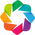

Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=2, name='1')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [2]:
# Visualization by PySOMVis
from pysomvis import PySOMVis

vis = PySOMVis(weights=weights['arr'], m=weights['ydim'],n=weights['xdim'],
                dimension=weights['vec_dim'], input_data=idata['arr'],
                classes=classes['arr'][:,1], component_names=classes['classes_names'])
vis._mainview

In [3]:
# Use any library for training SOM map (e.x. MiniSOM, SOMOClu, SOMpy, PopSOM etc.)
from pysomvis import PySOMVis
from minisom import MiniSom    

som = MiniSom(100, 60, 3, sigma=20, learning_rate=0.7)
som.train(idata['arr'], 30000, random_order=True, verbose=True)
som.dataset_name = "Chainlink"
vis = PySOMVis(weights=som._weights, input_data=idata['arr'])
vis._mainview

 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.07236822494339791


Column
    [0] Column
        [0] Column
            [0] Row(margin=(5, 10), width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↶')
                [4] Button(name='↷')
                [5] Button(name='↔')
                [6] Button(name='↕')
                [7] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', width=500)
            [1] Row
                [0] Column
                    [0] Column(margin=(5, 10), name='Component Planes')
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=2, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [4]:
import datetime
import json
from prov.model import ProvDocument, Namespace, PROV, Identifier
from pathlib import Path

Path("./prov_logs").mkdir(parents=True, exist_ok=True)
prov_info_log_counter = 1

def log_provenance(dataset, visualization, parameters, output_description):
    global prov_info_log_counter
    filename= f"prov_logs/provenance_cell{prov_info_log_counter}.json"
    prov_info_log_counter += 1
    
    doc = ProvDocument()
    doc.add_namespace("tp", "https://github.com/mwustinger/sos-ws2024/tree/main/exercise3")
    d = doc.entity("tp:Dataset", {"prov:label": dataset})
    v = doc.activity("tp:Visualization", None, None, {"prov:label": visualization})
    p = doc.entity("tp:Parameter", {"prov:label": parameters})

    if not isinstance(output_description, list):
        output_description = [output_description]
        
    for od in output_description:
        o = doc.entity("tp:Output", {"prov:label": od})
        doc.wasGeneratedBy(o, v)
        
    doc.used(v, d)
    doc.used(v, p)
    
    try:
        with open(filename, "w") as f:
            f.write(doc.serialize(indent=2, format="json") + "\n")
    except Exception as e:
        print(f"Failed to log provenance: {e}")

In [5]:
from topologic_product_calc import TopologicProductCalculator
import numpy as np
import matplotlib.pyplot as plt

def vis_all(som, k):
    topo_calc = TopologicProductCalculator(som)

    grid_y, grid_x = som._weights.shape[:2]
    
    input_distances = np.array([[topo_calc.P1(i, j, k) for j in range(grid_y)] for i in range(grid_x)])
    output_distances = np.array([[topo_calc.P2(i, j, k) for j in range(grid_y)] for i in range(grid_x)])
    topo_prod = np.array([[topo_calc.P3(i, j, k) for j in range(grid_y)] for i in range(grid_x)])
   
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    im0 = ax[0].imshow(np.swapaxes(input_distances, 0, 1), cmap='viridis') 
    ax[0].set_title("Distortion in Input Space")
    fig.colorbar(im0, ax=ax[0], label='Input Space Distortion')

    im1 = ax[1].imshow(np.swapaxes(output_distances, 0, 1), cmap='viridis') 
    ax[1].set_title("Distortion in Output Space")
    fig.colorbar(im1, ax=ax[1], label='Output Space Distortion')

    im2 = ax[2].imshow(np.swapaxes(topo_prod, 0, 1), cmap='viridis') 
    ax[2].set_title("Topological Product")
    fig.colorbar(im2, ax=ax[2], label='Topological Product')

    fig.tight_layout()
    plt.show()
    
    log_provenance(
        som.dataset_name, 
        "Distortions and Topological Product", 
        k, 
        ["Input Distortion Plot", "Output Distortion Plot", "Topological Product Plot"]
    )

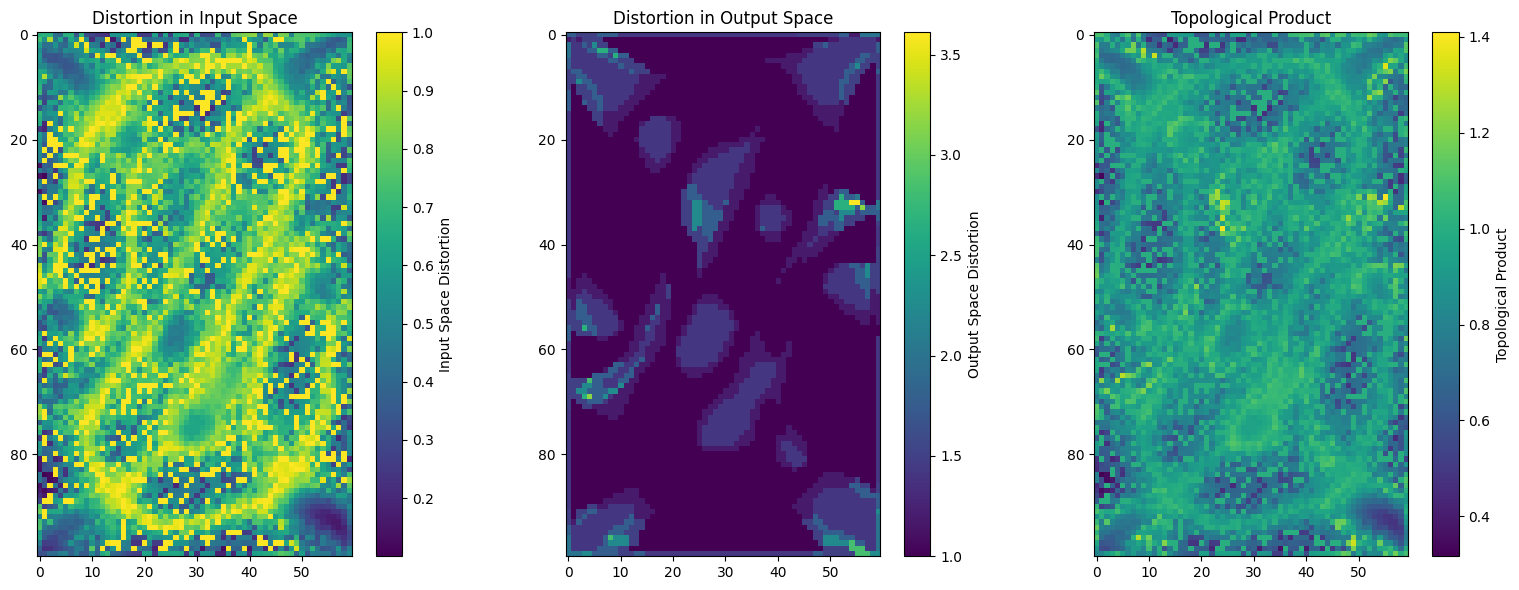

In [6]:
vis_all(som, 2)

In [7]:
def vis_input_dist(som, k):
    topo_calc = TopologicProductCalculator(som)

    grid_y, grid_x = som._weights.shape[:2]
    
    input_distances = np.array([[topo_calc.P1(i, j, k) for j in range(grid_y)] for i in range(grid_x)])

    plt.figure(figsize=(8, 6))
    plt.title("Distortion in Input Space")
    plt.imshow(np.swapaxes(input_distances, 0, 1), cmap='viridis')
    plt.colorbar(label='Input Space Distortion')
    plt.show()

    log_provenance(
        som.dataset_name, 
        "Input Distortion", 
        k, 
        "Input Distortion Plot"
    )

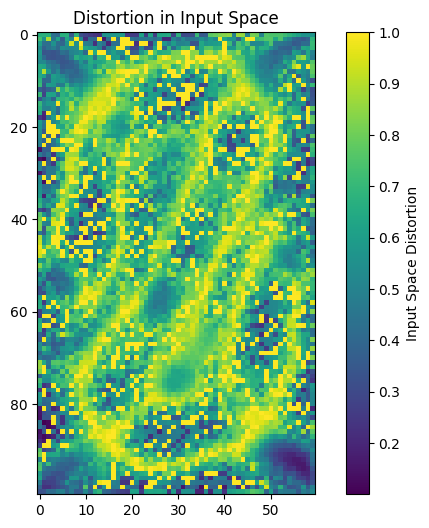

In [8]:
vis_input_dist(som, 2)

In [9]:
def vis_output_dist(som, k):
    topo_calc = TopologicProductCalculator(som)

    grid_y, grid_x = som._weights.shape[:2]
    
    output_distances = np.array([[topo_calc.P2(i, j, k) for j in range(grid_y)] for i in range(grid_x)])

    plt.figure(figsize=(8, 6))
    plt.title("Distortion in Output Space")
    plt.imshow(np.swapaxes(output_distances, 0, 1), cmap='viridis')
    plt.colorbar(label='Output Space Distortion')
    plt.show()

    log_provenance(
        som.dataset_name, 
        "Output Distortion", 
        k, 
        "Output Distortion Plot"
    )

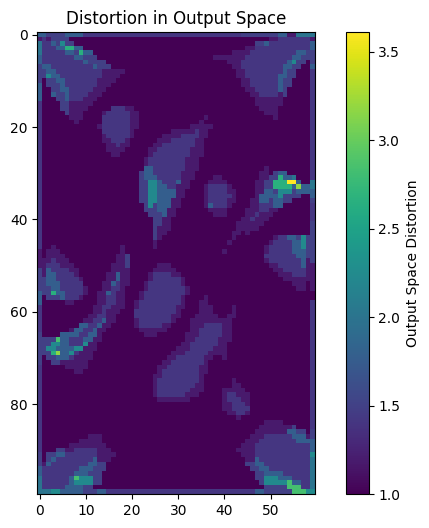

In [10]:
vis_output_dist(som, 2)

In [11]:
def vis_topo_prod(som, k):
    topo_calc = TopologicProductCalculator(som)

    grid_y, grid_x = som._weights.shape[:2]

    topo_prod = np.array([[topo_calc.P3(i, j, k) for j in range(grid_y)] for i in range(grid_x)])

    plt.figure(figsize=(8, 6))
    plt.title("Topological Product")
    plt.imshow(np.swapaxes(topo_prod, 0, 1), cmap='viridis')
    plt.colorbar(label='Topological Product')
    plt.show()

    log_provenance(
        som.dataset_name, 
        "Topological Product", 
        k, 
        "Topological Product Plot"
    )

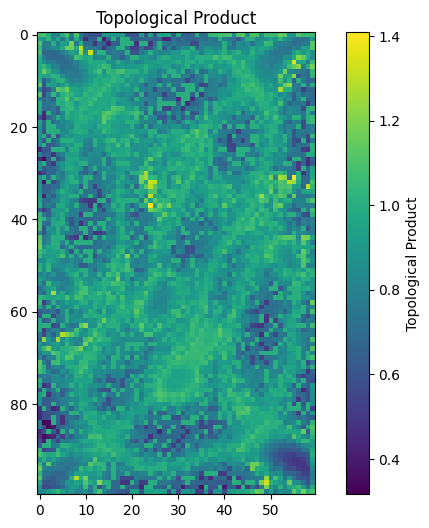

In [12]:
vis_topo_prod(som, 2)

## Testing